# Syntactic Feature Calculation

## Setup

In [1]:
# needs console command: python -m spacy download en
import spacy
import nltk
import pandas as pd
import ast
import prepare_data
import matplotlib.pyplot as plt
nlp = spacy.load('en', disable=['ner', 'textcat', 'tagger'])

## Counts

In [2]:
def plot_level(df,y_cols,title):
    x = list(range(1,len(y_cols)+1))
    y = [df[y_col] for y_col in y_cols]
    plt.title(title)
    plt.plot(x,y)
    plt.show()
    
def abs_to_rel_col(df,abs_col,len_col):
    text_lens = df[[len_col]].applymap(lambda x: x.count('ROOT'))
    return df[abs_col] / text_lens[len_col]

In [3]:
def count_all(df, deps):
    # TAKES: dataframe, names of columns where dependencies are located
    #df = count_rel_clauses(df, deps)
    #df = count_adv_clauses(df, deps)
    #df = count_adj_clauses(df, deps)
    df = count_clauses(df, deps)
    df = count_complements(df, deps)
    df = count_coord(df, deps)
    df = count_appos(df, deps)
    df = count_parataxis(df, deps)
    df = count_passive(df, deps)
    #df = count_active(df, deps)
    df = count_auxiliaries(df, deps)
    df = count_negation(df, deps)
    df = count_prep(df, deps)
    df = count_modifiers(df, deps)
    return df

# Relative clauses
def count_rel_clauses(df, deps):
    count = lambda x: x.count('relcl')
    for col in deps:
        df[str(col) + str('_relcl')] = df[col].apply(count)
    return df

# Adverbial phrases(clauses)
def count_adv_clauses(df, deps):
    count = lambda x: x.count('advcl')
    for col in deps:
        df[str(col) + str('_advcl')] = df[col].apply(count)
    return df

# Adjectival clauses
def count_adj_clauses(df, deps):
    count = lambda x: x.count('acl')
    for col in deps:
        df[str(col) + str('_acl')] = df[col].apply(count)
    return df

# Clauses together
def count_clauses(df, deps):
    count = lambda x: x.count('acl') + x.count('advcl') + x.count('relcl')
    for col in deps:
        df[str(col) + str('_cl')] = df[col].apply(count)
    return df

# Complements
def count_complements(df, deps):
    count = lambda x: x.count('ccomp') + x.count('xcomp')
    for col in deps:
        df[str(col) + str('_comp')] = df[col].apply(count)
    return df

# Coordination
def count_coord(df, deps):
    count = lambda x: x.count('cc')
    for col in deps:
        df[str(col) + str('_cc')] = df[col].apply(count)
    return df

# Apposition
def count_appos(df, deps):
    count = lambda x: x.count('appos')
    for col in deps:
        df[str(col) + str('_appos')] = df[col].apply(count)
    return df

# Passive voice
def count_passive(df, deps):
    count = lambda x: x.count('nsubjpass') + x.count('csubjpass')
    for col in deps:
        df[str(col) + str('_pass')] = df[col].apply(count)
    return df

# Active voice
def count_active(df, deps):
    count = lambda x: x.count('nsubj') + x.count('csubj')
    for col in deps:
        df[str(col) + str('_act')] = df[col].apply(count)
    return df

# Parataxis (non-conjunctive parenthetical/coordinated clause)
def count_parataxis(df, deps):
    count = lambda x: x.count('parataxis')
    for col in deps:
        df[str(col) + str('_para')] = df[col].apply(count)
    return df

# Auxiliaries - to measure verb complexity
def count_auxiliaries(df, deps):
    count = lambda x: x.count('aux') + x.count('auxpass')
    for col in deps:
        df[str(col) + str('_aux')] = df[col].apply(count)
    return df

# Negation
def count_negation(df, deps):
    count = lambda x: x.count('neg')
    for col in deps:
        df[str(col) + str('_neg')] = df[col].apply(count)
    return df

# Number of prepositional phrases
def count_prep(df, deps):
    count = lambda x: x.count('prep')
    for col in deps:
        df[str(col) + str('_prep')] = df[col].apply(count)
    return df

# Modifiers
def count_modifiers(df, deps):
    count = lambda x: x.count('advmod') + x.count('amod') + x.count('nummod') + x.count('nmod')
    for col in deps:
        df[str(col) + str('_mod')] = df[col].apply(count)
    return df

## Prepare Wikipedia dataset

In [35]:
raw = 'data/wikipedia_aligned.csv'
df_wiki = pd.read_csv(raw, sep='|')
df_wiki = df.rename(index=str, columns={"simple_sentence": "s_raw", "normal_sentence": "n_raw"})
# only has topics, #s, and raw

In [38]:
s_dep = []
for doc in nlp.pipe(df_wiki['s_raw'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        s_dep.append(tuple([n.dep_ for n in doc]))
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        s_dep.append(None)

df_wiki['s_dep'] = s_dep 

# This took 8 minutes on my laptop

In [39]:
n_dep = []
for doc in nlp.pipe(df_wiki['n_raw'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        n_dep.append(tuple([n.dep_ for n in doc]))
    else:
        n_dep.append(None)

df_wiki['n_dep'] = n_dep  

# also 8 minutes

# now df has s_dep and n_dep

In [ ]:
prepare_data.save_df('data/wikipedia_aligned_dep.csv', df_wiki)

In [52]:
# Having done this already - read the dep file.
aligned_cols = ['s_dep', 'n_dep']
df_wiki = prepare_data.load_df('data/wikipedia_aligned_dep.csv', aligned_cols)

In [54]:
df_wiki = count_all(df_wiki, ['s_dep', 'n_dep'])

In [56]:
cols = list(df_wiki)
cols.remove('simple_topic')
cols.remove('simple_numb')
cols.remove('s_raw')
cols.remove('s_dep')
cols.remove('normal_topic')
cols.remove('normal_numb')
cols.remove('n_raw')
cols.remove('n_dep')

for col in cols:
    print(col + '\t' + str(df_wiki[col].sum()))

s_dep_cl	69771
n_dep_cl	90075
s_dep_comp	30958
n_dep_comp	31647
s_dep_cc	76157
n_dep_cc	98136
s_dep_appos	31363
n_dep_appos	40183
s_dep_para	266
n_dep_para	325
s_dep_pass	39525
n_dep_pass	38249
s_dep_aux	86463
n_dep_aux	90636
s_dep_neg	6172
n_dep_neg	5861
s_dep_prep	299074
n_dep_prep	364000
s_dep_mod	372396
n_dep_mod	467007


In [57]:
prepare_data.save_df('data/wikipedia_aligned_dep_features.csv', df_wiki)

## British 3-level corpus

In [58]:
df_brit = prepare_data.load_df('data/british_council/cleaned_articles.csv', ['cleaned1', 'cleaned2', 'cleaned3'])

In [59]:
dep1 = []
for doc in nlp.pipe(df_brit['cleaned1'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        dep1.append(tuple([n.dep_ for n in doc]))
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        dep1.append(None)

df_brit['dep1'] = dep1 

dep2 = []
for doc in nlp.pipe(df_brit['cleaned2'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        dep2.append(tuple([n.dep_ for n in doc]))
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        dep1.append(None)

df_brit['dep2'] = dep2

dep3 = []
for doc in nlp.pipe(df_brit['cleaned3'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        dep3.append(tuple([n.dep_ for n in doc]))
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        dep1.append(None)

df_brit['dep3'] = dep3 

In [69]:
df_brit = count_all(df_brit, ['dep1', 'dep2', 'dep3'])
prepare_data.save_df('data/british_council/syntactic_features.csv', df_brit)

In [61]:
cleaned1txt = [nltk.sent_tokenize(sent) for sent in df_brit['cleaned3'][0]]
num = 0
for item in cleaned1txt:
    num += len(item)
    
from collections import Counter

print(num)
print(Counter(df_brit['dep3'][0]))
#print()
#print(df_brit['cleaned2'][0])
#print()
#print(df_brit['cleaned3'][0])

151
Counter({'punct': 325, 'nsubj': 181, 'ROOT': 155, 'prep': 103, 'pobj': 100, 'det': 83, 'aux': 77, 'dobj': 68, 'advmod': 67, 'cc': 57, 'conj': 52, 'poss': 44, 'neg': 28, 'ccomp': 23, 'amod': 20, 'acomp': 19, 'attr': 17, 'npadvmod': 17, 'xcomp': 16, 'advcl': 15, 'mark': 14, 'intj': 11, 'compound': 6, 'prt': 6, 'relcl': 5, 'expl': 4, 'dep': 4, 'parataxis': 4, 'appos': 4, 'auxpass': 4, 'case': 2, 'pcomp': 2, 'nsubjpass': 2, 'predet': 2, 'csubj': 1, '': 1, 'acl': 1, 'nmod': 1, 'nummod': 1, 'dative': 1})


In [62]:
cols = list(df_brit)
cols.remove('article_name')
cols.remove('cleaned1')
cols.remove('cleaned2')
cols.remove('cleaned3')
cols.remove('dep1')
cols.remove('dep2')
cols.remove('dep3')

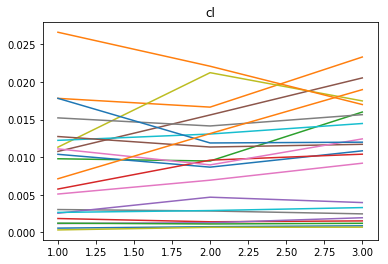

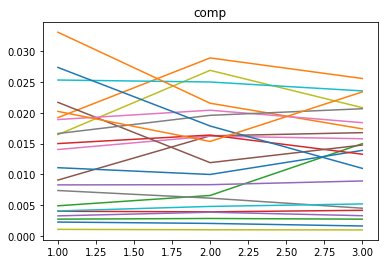

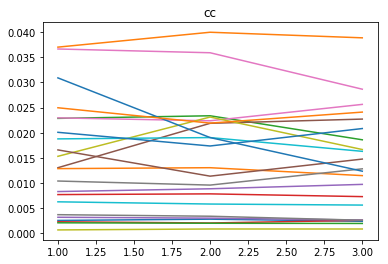

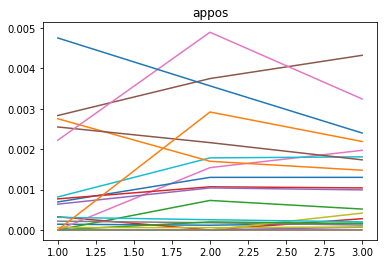

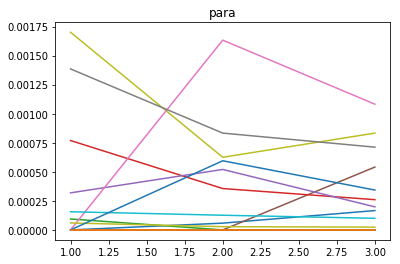

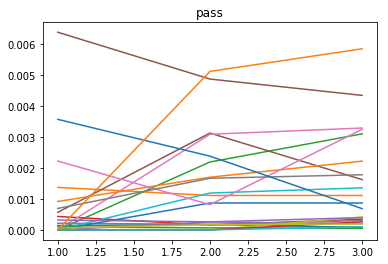

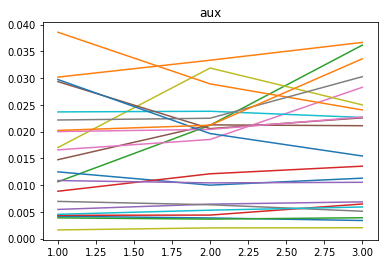

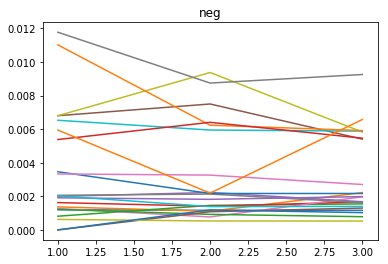

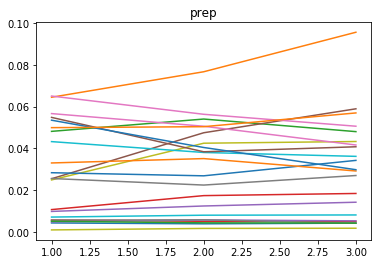

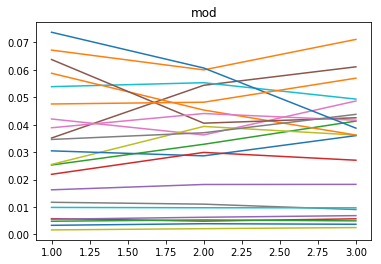

In [68]:
for idx in range(0,len(cols),3):
    df_brit[cols[idx]] = abs_to_rel_col(df_brit, cols[idx], 'dep1')
    df_brit[cols[idx+1]] = abs_to_rel_col(df_brit, cols[idx+1], 'dep2')
    df_brit[cols[idx+2]] = abs_to_rel_col(df_brit, cols[idx+2], 'dep3')
    plot_level(df_brit, [cols[idx], cols[idx+1], cols[idx+2]], cols[idx][5:])

In [64]:
df_brit.head()

,article_name,cleaned1,cleaned2,cleaned3,dep1,dep2,dep3,dep1_cl,dep2_cl,dep3_cl,...,dep3_aux,dep1_neg,dep2_neg,dep3_neg,dep1_prep,dep2_prep,dep3_prep,dep1_mod,dep2_mod,dep3_mod
0,walk-forest-level,[Going through the forest is my favourite part...,[Going through the forest is my favourite part...,[Going through the forest is my favourite part...,"(punct, punct, csubj, prep, det, pobj, ROOT, p...","(punct, punct, csubj, prep, det, pobj, ROOT, p...","(punct, punct, csubj, prep, det, pobj, ROOT, p...",0.067227,0.099237,0.135484,...,0.522581,0.142857,0.152672,0.180645,0.521008,0.519084,0.664516,0.394958,0.511450,0.574194
1,amazing-adventurers-level,[Do you ever dream about climbing Mount Everes...,[Have you ever dreamt of climbing Mount Everes...,[Have you ever dreamt of climbing Mount Everes...,"(punct, punct, aux, nsubj, advmod, ROOT, prep,...","(punct, punct, aux, nsubj, advmod, ROOT, prep,...","(punct, punct, aux, nsubj, advmod, ROOT, prep,...",0.481481,0.500000,0.700000,...,1.100000,0.037037,0.033333,0.066667,1.740741,2.300000,2.866667,1.814815,1.800000,2.133333
2,animals-city-level,"[One night in December 2011, a bear came into ...","[Recently, there have been many reports in new...","[Small animals like birds, squirrels, mice and...","(punct, punct, nummod, npadvmod, prep, pobj, n...","(punct, punct, advmod, punct, expl, aux, ROOT,...","(punct, punct, amod, nsubj, prep, pobj, punct,...",0.342857,0.351351,0.704545,...,1.590909,0.028571,0.054054,0.068182,1.685714,2.000000,2.113636,0.885714,1.216216,1.818182
3,bully-level,[Kay got another message as she was leaving fo...,[Kay got another message as she was leaving fo...,[Kay got another message as she was leaving fo...,"(punct, punct, nsubj, ccomp, det, dobj, mark, ...","(punct, punct, nsubj, ccomp, det, dobj, mark, ...","(punct, punct, nsubj, ccomp, det, dobj, mark, ...",0.177083,0.159292,0.183333,...,0.775000,0.156250,0.159292,0.200000,0.552083,0.584071,0.616667,0.552083,0.548673,0.683333
4,cheat-level,[Mo was waiting outside her class. She was fee...,[Mo was waiting in the corridor outside her cl...,[Mo was waiting in the corridor with her class...,"(punct, punct, nsubj, aux, ROOT, prep, poss, p...","(punct, punct, nsubj, aux, ROOT, prep, det, po...","(punct, punct, nsubj, aux, ROOT, prep, det, po...",0.123810,0.138889,0.237705,...,0.836066,0.209524,0.240741,0.204918,0.514286,0.629630,0.655738,0.580952,0.675926,0.836066
